In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom import dcmread
import albumentations as A
import cv2
%matplotlib inline
from tqdm.notebook import tqdm

In [3]:
# Adding all files here
files = [os.path.join('../data/', i) for i in os.listdir('../data/') if i.endswith('.csv')]
files

['../data/sample_submission.csv',
 '../data/train_study_level.csv',
 '../data/train_image_level.csv']

In [3]:
train_study = pd.read_csv(files[1])
train_image = pd.read_csv(files[2])

In [4]:
train_image.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [5]:
eval(train_image['boxes'].iloc[0])

[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292},
 {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]

In [6]:
train_image['label'].iloc[0]

'opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472'

In [7]:
train_study['id'] = train_study['id'].apply(lambda x: re.sub('_study','',x).strip())

In [8]:
train_study.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852,0,1,0,0
1,000c9c05fd14,0,0,0,1
2,00292f8c37bd,1,0,0,0
3,005057b3f880,1,0,0,0
4,0051d9b12e72,0,0,0,1


In [9]:
train_image[train_image['StudyInstanceUID']=='00086460a852']

,id,boxes,label,StudyInstanceUID
2498,65761e66de9f_image,"[{'x': 720.65215, 'y': 636.51048, 'width': 332...",opacity 1 720.65215 636.51048 1052.84563 1284....,00086460a852


In [10]:
train_image.shape, train_study.shape

((6334, 4), (6054, 5))

# Joining Image & Study

Dropping NaNs in train_image

In [11]:
train_image.isnull().sum()/train_image.shape[0], train_study.isnull().sum()/train_study.shape[0]

(id                  0.000000
 boxes               0.322071
 label               0.000000
 StudyInstanceUID    0.000000
 dtype: float64,
 id                          0.0
 Negative for Pneumonia      0.0
 Typical Appearance          0.0
 Indeterminate Appearance    0.0
 Atypical Appearance         0.0
 dtype: float64)

In [12]:
train_image.dropna(inplace=True)

In [13]:
df = train_image.merge(train_study, left_on=['StudyInstanceUID'], right_on=['id'], how='inner')

In [14]:
df.drop(columns='id_y', inplace=True)
df.rename(columns={'id_x':'image_id'}, inplace=True)

In [15]:
df.shape

(4294, 8)

# Checking Uniqueness of IDs

In [16]:
train_image['StudyInstanceUID'].value_counts()

c25d9133b16e    1
8d0a46af75e9    1
be71d3607cf2    1
9e6e8142ca4f    1
717649076168    1
               ..
2c78ef584129    1
e13f252bf83c    1
1972681565cc    1
e2afeb565737    1
4dd1c6cd167e    1
Name: StudyInstanceUID, Length: 4294, dtype: int64

In [17]:
train_study['id'].value_counts()

c25d9133b16e    1
a5c349de688d    1
835dd3c81c51    1
818bda3ca15d    1
acec4f0cbd17    1
               ..
101c3d954b1a    1
d97dffd12359    1
207758407af9    1
e1c1ad4b1e61    1
4dd1c6cd167e    1
Name: id, Length: 6054, dtype: int64

In [18]:
train_image[train_image['StudyInstanceUID']=='0fd2db233deb']

,id,boxes,label,StudyInstanceUID
964,26f643772090_image,"[{'x': 561.30269, 'y': 163.28797, 'width': 883...",opacity 1 561.30269 163.28797 1445.02377 1495....,0fd2db233deb


# Checking Images

In [19]:
train_folder =  '../data/train/'

In [20]:
train_image['id'] = train_image['id'].apply(lambda x: re.sub('_image','',x).strip())

In [21]:
image_ids = tuple(zip(train_image['id'], train_image['StudyInstanceUID']))

In [22]:
image_ids[0]

('000a312787f2', '5776db0cec75')

In [23]:
def check_image_match(path, x):
    try:
        for i in os.listdir(path):
            z = os.listdir(f'{path}{i}')[0]
            if z==x:
                l = path+i
                return os.path.join(l, x)
    except:
        return None

In [24]:
 image_path = os.path.join(train_folder, '0fd2db233deb/')
 image_path

'../data/train/0fd2db233deb/'

In [25]:
check_image_match(image_path, '26f643772090.dcm')

'../data/train/0fd2db233deb/9025f953c3d2/26f643772090.dcm'

In [26]:
train_folder =  '../data/train/'
z = []
for i,j in tqdm(image_ids):
    image_path = os.path.join(train_folder, f'{j}/')
    z.append(check_image_match(image_path, f'{i}.dcm'))


  0%|          | 0/4294 [00:00<?, ?it/s]

In [27]:
df['image_path'] = z

In [28]:
df.isnull().sum()

image_id                      0
boxes                         0
label                         0
StudyInstanceUID              0
Negative for Pneumonia        0
Typical Appearance            0
Indeterminate Appearance      0
Atypical Appearance           0
image_path                  170
dtype: int64

In [29]:
k = df[~df['image_path'].isna()].reset_index(drop=True)

# Loading Sample Dicom Images

In [30]:
k['image_path'].iloc[0]

'../data/train/5776db0cec75/81456c9c5423/000a312787f2.dcm'

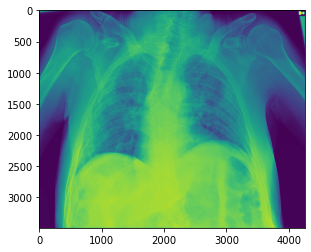

In [34]:
plt.imshow(dcmread(k['image_path'].iloc[0]).pixel_array)

In [127]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 100, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=20):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0, 2)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=10.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids=None, category_id_to_name=None):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [128]:
def get_sample_image():
    i = np.random.randint(low=0, high=df.shape[0]-1)
    category_ids = [17, 18]
    print(i)
    # # We will use the mapping from category_id to the class name
    # # to visualize the class label for the bounding box on the image
    category_id_to_name = {17: 'RL', 18: 'LL'}
    bb = eval(df['boxes'].iloc[0])
    bboxes = [list(i.values()) for i in bb]
    image = dcmread(k['image_path'].iloc[0]).pixel_array
    visualize(image, bboxes, category_ids, category_id_to_name)

In [129]:
np.random.seed(0)

2732


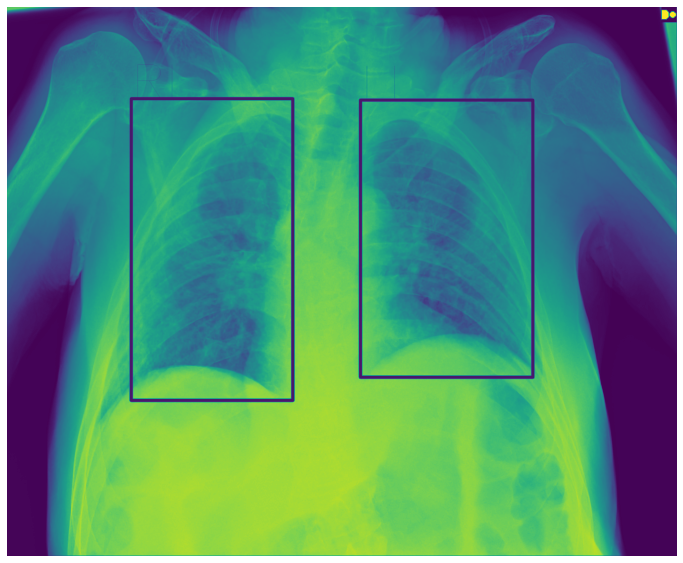

In [130]:
get_sample_image()

2607


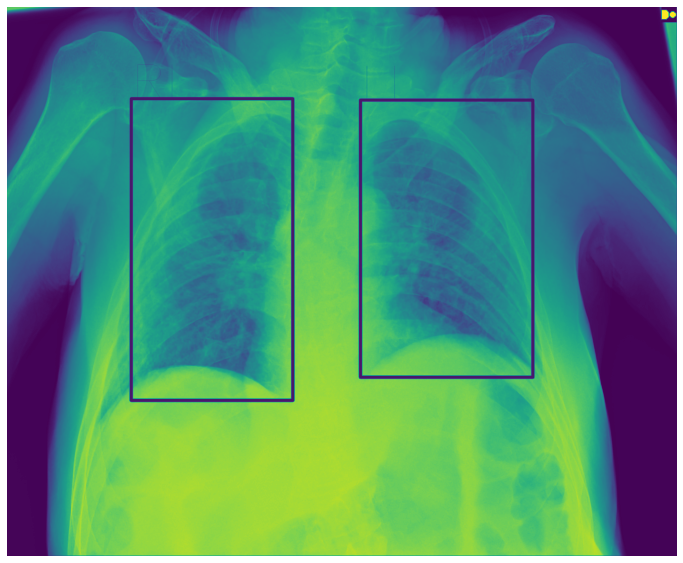

In [131]:
get_sample_image()

In [132]:
import torch